# Peak shaving vs TCIPC analysis.

## Loading data

In [1]:
import socket

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata
from weis.visualization.utils import load_OMsql_multi
from cmcrameri import cm

socket.gethostname()  # Should not be a login node.

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.DeprecationWarning: /home/jesse/miniconda3/envs/tip_clearance/lib/python3.13/site-packages/pkg_resources/__init__.py:3146
Deprecated call to `pkg_resources.declare_namespace('sphinxcontrib')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packagesDeprecationWarning: /home/jesse/miniconda3/envs/tip_clearance/lib/python3.13/site-packages/jsonmerge/__init__.py:27
Accessing Draft4Validator.resolver is deprecated as of v4.18.0, in favor of the https://github.com/python-jsonschema/referencing library, which provides more compliant referencing behavior as well as more flexible APIs for customization.PendingDeprecati

'J1YCSV3'

In [2]:
# Define the logs to load and compare
logs_to_load = {
    "Free yaw": "../../data/design_of_experiments/ps_vs_ipc/log_ps_vs_ipc.sql*",
    "Zero yaw deflection": "../../data/design_of_experiments/ps_vs_ipc_zero_yaw_deflection/log_ps_vs_ipc_zero_yaw_deflection.sql*",
}

# Load all datasets
all_data_dicts = {}
for log_name, log_fmt in logs_to_load.items():
    all_data_dicts[log_name] = load_OMsql_multi(log_fmt)
    print(f"Loaded {log_name}: {all_data_dicts[log_name].keys()}")

This process (pid=11095) is multi-threaded, use of fork() may lead to deadlocks in the child.

Loaded Free yaw: dict_keys(['aeroelastic.platform_displacement', 'aeroelastic.hub_system_cm', 'aeroelastic.platform_elem_rho', 'aeroelastic.platform_elem_E', 'aeroelastic.platform_elem_G', 'aeroelastic.platform_total_center_of_mass', 'aeroelastic.platform_mass', 'aeroelastic.platform_I_total', 'aeroelastic.beta_wave', 'aeroelastic.gamma_f', 'aeroelastic.gamma_m', 'aeroelastic.E', 'aeroelastic.twr2shaft', 'aeroelastic.Xt', 'aeroelastic.Xc', 'aeroelastic.m', 'aeroelastic.definition_layer', 'aeroelastic.sc_ss_mats', 'aeroelastic.sc_ps_mats', 'aeroelastic.te_ss_mats', 'aeroelastic.te_ps_mats', 'aeroelastic.monopile_wohlerexp', 'aeroelastic.monopile_wohlerA', 'aeroelastic.monopile_ultstress', 'aeroelastic.pitch_axis', 'aeroelastic.monopile_axial_load2stress', 'aeroelastic.monopile_shear_load2stress', 'aeroelastic.transition_node', 'aeroelastic.platform_nodes', 'aeroelastic.platform_elem_n1', 'aeroelastic.platform_elem_n2', 'aeroelastic.platform_elem_D', 'aeroelastic.platform_elem_t', 'aeroe

This process (pid=11095) is multi-threaded, use of fork() may lead to deadlocks in the child.

Loaded Zero yaw deflection: dict_keys(['aeroelastic.platform_displacement', 'aeroelastic.hub_system_cm', 'aeroelastic.platform_elem_rho', 'aeroelastic.platform_elem_E', 'aeroelastic.platform_elem_G', 'aeroelastic.platform_total_center_of_mass', 'aeroelastic.platform_mass', 'aeroelastic.platform_I_total', 'aeroelastic.beta_wave', 'aeroelastic.gamma_f', 'aeroelastic.gamma_m', 'aeroelastic.E', 'aeroelastic.twr2shaft', 'aeroelastic.Xt', 'aeroelastic.Xc', 'aeroelastic.m', 'aeroelastic.definition_layer', 'aeroelastic.sc_ss_mats', 'aeroelastic.sc_ps_mats', 'aeroelastic.te_ss_mats', 'aeroelastic.te_ps_mats', 'aeroelastic.monopile_wohlerexp', 'aeroelastic.monopile_wohlerA', 'aeroelastic.monopile_ultstress', 'aeroelastic.pitch_axis', 'aeroelastic.monopile_axial_load2stress', 'aeroelastic.monopile_shear_load2stress', 'aeroelastic.transition_node', 'aeroelastic.platform_nodes', 'aeroelastic.platform_elem_n1', 'aeroelastic.platform_elem_n2', 'aeroelastic.platform_elem_D', 'aeroelastic.platform_elem

In [3]:
# Plot settings.
text_width_in = 455.24408 / 64
default_fig_width = 0.9 * text_width_in
default_aspect_ratio = 1 / (0.5 * (1 + np.sqrt(5)))

plt.rcParams.update(
    {
        "font.family": "serif",
        "font.serif": ["Latin Modern Roman"],
        "font.size": 10,
        "text.usetex": False,
        "pdf.fonttype": 42,  # TrueType fonts for better PDF embedding
        "ps.fonttype": 42,
        "figure.figsize": [default_fig_width, default_fig_width * default_aspect_ratio],
        "image.cmap": "cmc.batlow",
        "axes.prop_cycle": plt.cycler(color=["#26576D", "#6DC29B", "#ECD89E"]),
    }
)

In [4]:
# Let's define how we load, scale, and label the data, then make a dataframe.
all_outputs = {
    "rank": {
        "key": "rank",
        "scaling": lambda x: x,
        "label": "rank",
    },
    "iter": {
        "key": "iter",
        "scaling": lambda x: x,
        "label": "iter",
    },
    # ROSCO variables.
    "TCIPC_MaxTipDeflection": {
        "key": "tune_rosco_ivc.TCIPC_MaxTipDeflection",
        "scaling": lambda x: x,
        "label": "TCIPC Max Tip Deflection (m)",
    },
    "ps_percent": {
        "key": "tune_rosco_ivc.ps_percent",
        "scaling": lambda x: x,
        "label": "Peak Shaving (%)",
    },
    "TCIPC_nHarmonics": {
        "key": "tune_rosco_ivc.TCIPC_nHarmonics",
        "scaling": lambda x: x,
        "label": "Number of harmonics",
    },
    "TCIPC_ZeroYawDeflection": {
        "key": "tune_rosco_ivc.TCIPC_ZeroYawDeflection",
        "scaling": lambda x: x,
        "label": "Zero yaw deflection",
    },
    # Objectives / responses
    "aep": {
        "key": "aeroelastic.AEP",
        "scaling": lambda x: 1e-6 * x,  # kWh -> GWh
        "label": "AEP (GWh)",
    },
    "max_TipDxc_towerPassing": {
        "key": "aeroelastic.max_TipDxc_towerPassing",
        "scaling": lambda x: x,
        "label": "Max TipDxc Tower Passing (m)",
    },
    "tower_clearance": {
        "key": "aeroelastic.max_TipDxc_towerPassing",
        "scaling": lambda x: 30 - x,
        "label": "Tower clearance (m)",
    },
    "avg_pitch_travel": {
        "key": "aeroelastic.avg_pitch_travel",
        "scaling": lambda x: x,
        "label": "Avg Pitch Travel (deg)",
    },
    "DEL_RootMyb": {
        "key": "aeroelastic.DEL_RootMyb",
        "scaling": lambda x: x,  # Assuming kNm already
        "label": "DEL Root Myb (kNm)",
    },
    "max_TwrBsMyt": {
        "key": "aeroelastic.max_TwrBsMyt",
        "scaling": lambda x: x,  # Assuming kNm already
        "label": "Max Tower Base Myt (kNm)",
    },
}

# Build dataframe from mapping for each log
labels = {short: info["label"] for short, info in all_outputs.items()}
all_dfs = []

for log_name, data_dict in all_data_dicts.items():
    df_dict = {}
    for short_label, info in all_outputs.items():
        data = data_dict[info["key"]]
        scaled_data = list(map(info["scaling"], data))
        df_dict[short_label] = scaled_data

    df_temp = pd.DataFrame(df_dict)
    df_temp["log_name"] = log_name  # Add identifier column
    all_dfs.append(df_temp)

# Combine all dataframes
df = pd.concat(all_dfs, ignore_index=True)
print(f"Combined dataframe shape: {df.shape}")
df.head()

Combined dataframe shape: (72, 13)


,rank,iter,TCIPC_MaxTipDeflection,ps_percent,TCIPC_nHarmonics,TCIPC_ZeroYawDeflection,aep,max_TipDxc_towerPassing,tower_clearance,avg_pitch_travel,DEL_RootMyb,max_TwrBsMyt,log_name
0,0,0,0.0,0.5,5.0,0.0,69.815186,6.494825,23.505175,1.388384,40415.896377,237903.234375,Free yaw
1,0,1,8.0,0.5,5.0,0.0,69.343432,10.679102,19.320898,0.506746,20757.833660,205974.750000,Free yaw
2,0,2,16.0,0.5,5.0,0.0,69.324209,10.981573,19.018427,0.490066,20649.244104,203311.265625,Free yaw
3,0,3,0.0,0.6,5.0,0.0,77.221127,7.661289,22.338711,1.477610,42353.963816,249946.796875,Free yaw
4,0,4,8.0,0.6,5.0,0.0,76.153495,10.978742,19.021258,0.577341,22437.814818,236646.390625,Free yaw


## Some sanity checks

<Axes: xlabel='TCIPC_MaxTipDeflection', ylabel='ps_percent'>

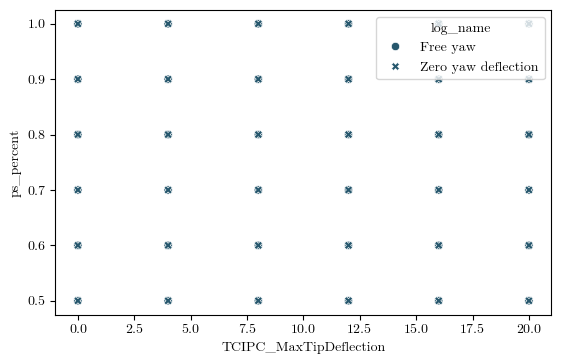

In [20]:
# Make a plot of the distribution of our design variables.
sns.scatterplot(df, x="TCIPC_MaxTipDeflection", y="ps_percent", style="log_name")

## Data exploration

In [21]:
# Filter for free yaw case only for data exploration
df_free_yaw = df[df["log_name"] == "Free yaw"].copy()

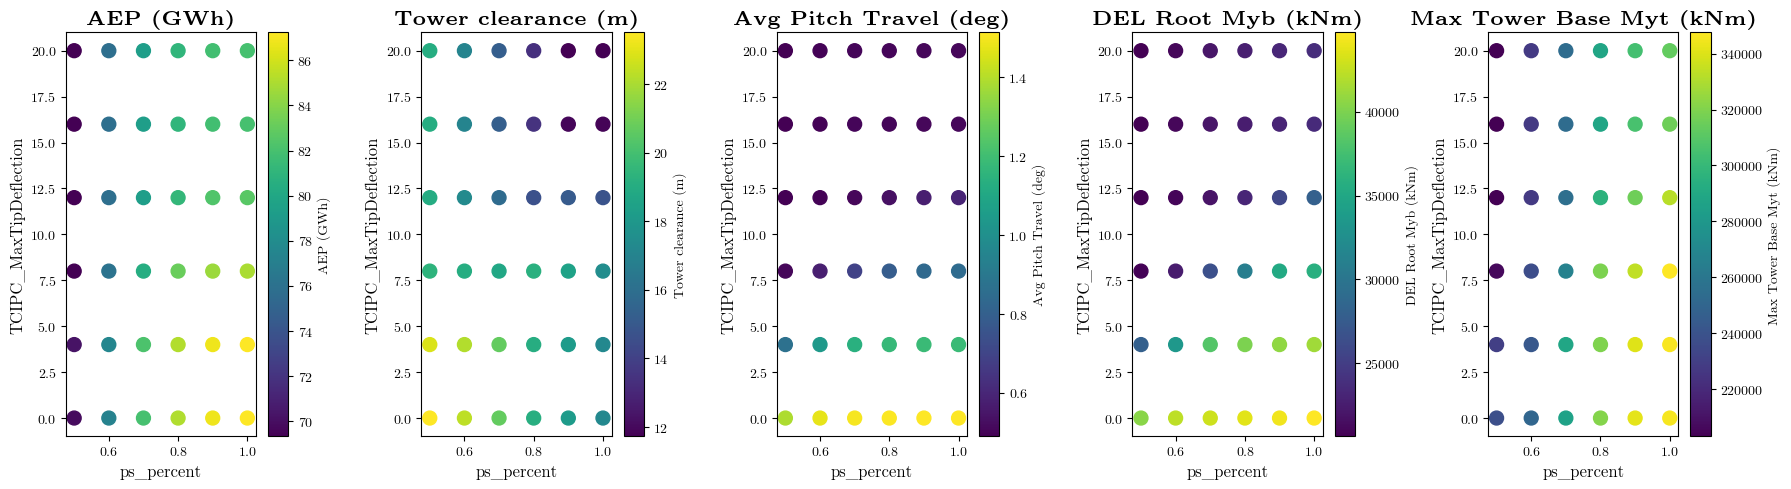

In [22]:
# Plot the objectives as a function of our design variables (Free yaw only).

# Output variables to plot (use short names)
outputs = [
    "aep",
    "tower_clearance",
    "avg_pitch_travel",
    "DEL_RootMyb",
    "max_TwrBsMyt",
]

# Create figure with enough subplots for the outputs.
fig, axes = plt.subplots(1, len(outputs), figsize=(18, 5))

# Create scatter plots with color representing each output
for idx, output in enumerate(outputs):
    scatter = axes[idx].scatter(
        df_free_yaw["ps_percent"],
        df_free_yaw["TCIPC_MaxTipDeflection"],
        c=df_free_yaw[output],
        cmap="viridis",
        s=100,
    )
    axes[idx].set_xlabel("ps_percent", fontsize=12)
    axes[idx].set_ylabel("TCIPC_MaxTipDeflection", fontsize=12)
    label_txt = labels.get(output, output)
    axes[idx].set_title(label_txt, fontsize=14, fontweight="bold")
    plt.colorbar(scatter, ax=axes[idx], label=label_txt)

plt.tight_layout()
plt.show()


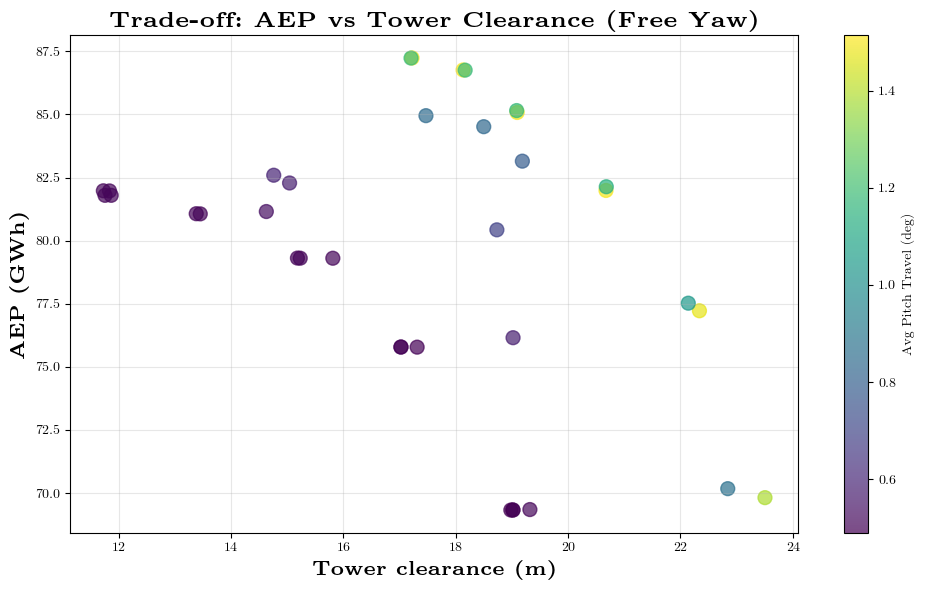

In [23]:
# Trade-off plot between AEP and Tower Clearance (Free yaw only)
fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(
    df_free_yaw["tower_clearance"],
    df_free_yaw["aep"],
    c=df_free_yaw["avg_pitch_travel"],
    cmap="viridis",
    s=100,
    alpha=0.7,
)

ax.set_xlabel(
    labels.get("tower_clearance", "Tower Clearance (m)"), fontsize=14, fontweight="bold"
)
ax.set_ylabel(labels["aep"], fontsize=14, fontweight="bold")
ax.set_title(
    "Trade-off: AEP vs Tower Clearance (Free Yaw)", fontsize=16, fontweight="bold"
)
plt.colorbar(scatter, ax=ax, label=labels["avg_pitch_travel"])
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Data interpolation

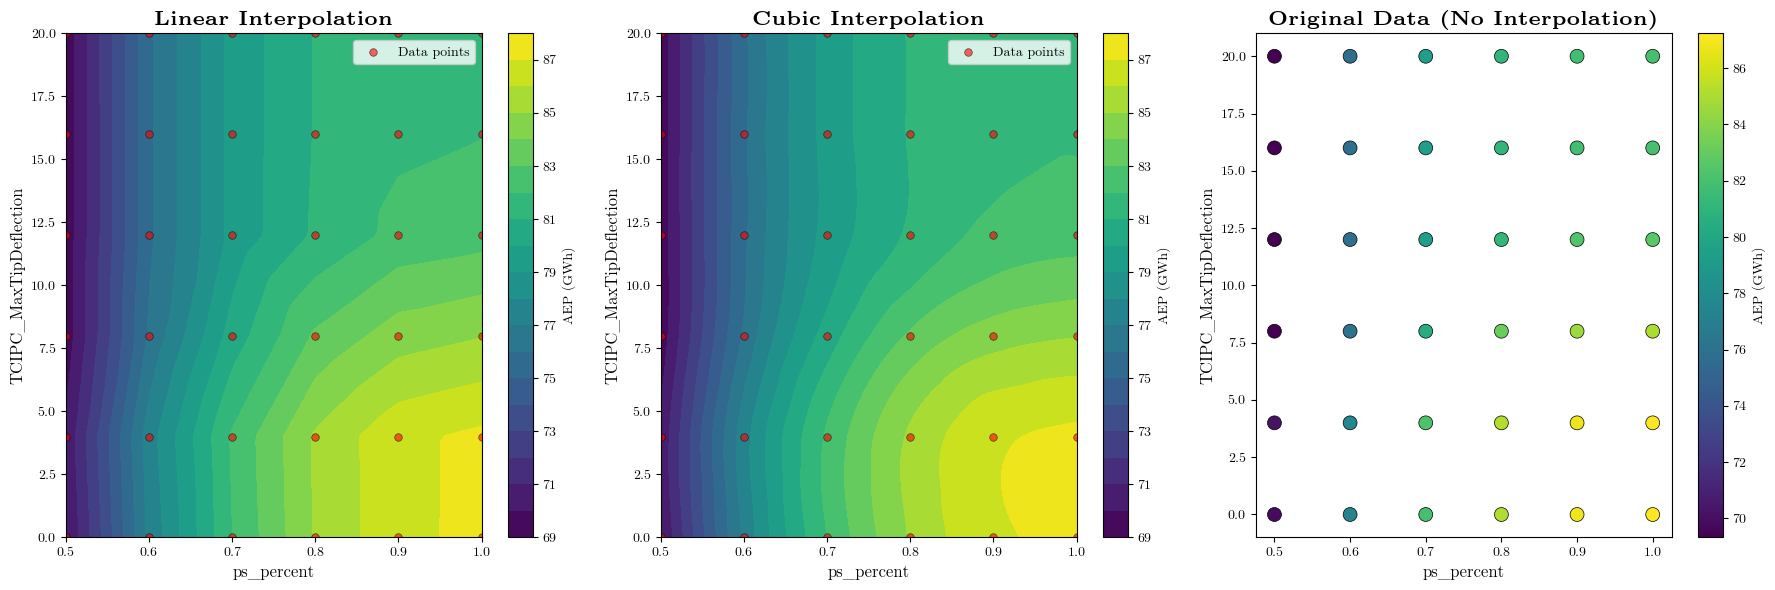

In [24]:
# What type of interpolation should we use? From this I think cubic interpolation works
# very well. (Free yaw only)
ps_min, ps_max = (
    df_free_yaw["ps_percent"].min(),
    df_free_yaw["ps_percent"].max(),
)
tip_min, tip_max = (
    df_free_yaw["TCIPC_MaxTipDeflection"].min(),
    df_free_yaw["TCIPC_MaxTipDeflection"].max(),
)

# Create meshgrid for interpolation
grid_ps = np.linspace(ps_min, ps_max, 100)
grid_tip = np.linspace(tip_min, tip_max, 100)
grid_ps_mesh, grid_tip_mesh = np.meshgrid(grid_ps, grid_tip)

# Prepare input points
points = df_free_yaw[["ps_percent", "TCIPC_MaxTipDeflection"]].values

# Output to interpolate (use scaled aep)
output = "aep"
values = df_free_yaw[output].values

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Linear interpolation
grid_z = griddata(points, values, (grid_ps_mesh, grid_tip_mesh), method="linear")
im = axes[0].contourf(grid_ps_mesh, grid_tip_mesh, grid_z, levels=20, cmap="viridis")
axes[0].scatter(
    df_free_yaw["ps_percent"],
    df_free_yaw["TCIPC_MaxTipDeflection"],
    c="red",
    s=30,
    edgecolors="black",
    linewidth=0.5,
    alpha=0.6,
    label="Data points",
)
axes[0].set_xlabel("ps_percent", fontsize=12)
axes[0].set_ylabel("TCIPC_MaxTipDeflection", fontsize=12)
axes[0].set_title("Linear Interpolation", fontsize=14, fontweight="bold")
plt.colorbar(im, ax=axes[0], label="AEP (GWh)")
axes[0].legend()

# Cubic interpolation
grid_z = griddata(points, values, (grid_ps_mesh, grid_tip_mesh), method="cubic")
im = axes[1].contourf(grid_ps_mesh, grid_tip_mesh, grid_z, levels=20, cmap="viridis")
axes[1].scatter(
    df_free_yaw["ps_percent"],
    df_free_yaw["TCIPC_MaxTipDeflection"],
    c="red",
    s=30,
    edgecolors="black",
    linewidth=0.5,
    alpha=0.6,
    label="Data points",
)
axes[1].set_xlabel("ps_percent", fontsize=12)
axes[1].set_ylabel("TCIPC_MaxTipDeflection", fontsize=12)
axes[1].set_title("Cubic Interpolation", fontsize=14, fontweight="bold")
plt.colorbar(im, ax=axes[1], label="AEP (GWh)")
axes[1].legend()

# Original scatter for comparison
scatter = axes[2].scatter(
    df_free_yaw["ps_percent"],
    df_free_yaw["TCIPC_MaxTipDeflection"],
    c=values,
    cmap="viridis",
    s=100,
    edgecolors="black",
    linewidth=0.5,
)
axes[2].set_xlabel("ps_percent", fontsize=12)
axes[2].set_ylabel("TCIPC_MaxTipDeflection", fontsize=12)
axes[2].set_title("Original Data (No Interpolation)", fontsize=14, fontweight="bold")
plt.colorbar(scatter, ax=axes[2], label="AEP (GWh)")

plt.tight_layout()
plt.show()


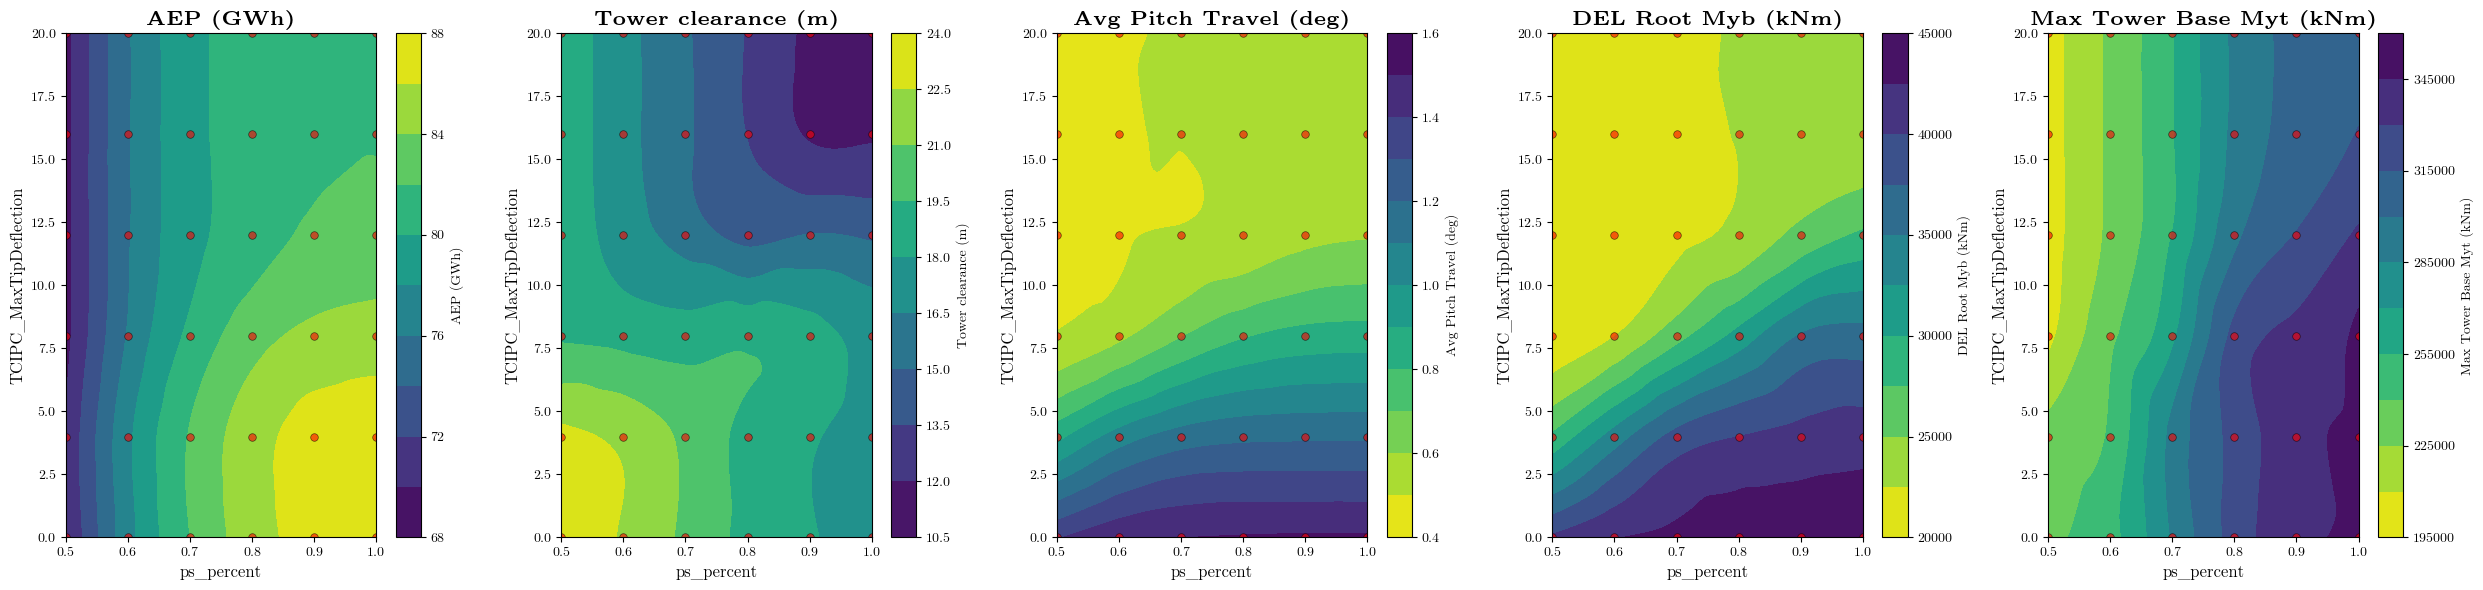

In [25]:
# Cubic interpolation for all selected outputs (Free yaw only)
fig, axes = plt.subplots(1, len(outputs), figsize=(25, 6))

# Use some reverse color maps when it is an objective we want to minimize.
cmaps = ["viridis", "viridis", "viridis_r", "viridis_r", "viridis_r"]

for idx, output in enumerate(outputs):
    values = df_free_yaw[output].values

    # Cubic interpolation
    grid_z = griddata(points, values, (grid_ps_mesh, grid_tip_mesh), method="cubic")
    im = axes[idx].contourf(
        grid_ps_mesh, grid_tip_mesh, grid_z, levels=10, cmap=cmaps[idx]
    )
    axes[idx].scatter(
        df_free_yaw["ps_percent"],
        df_free_yaw["TCIPC_MaxTipDeflection"],
        c="red",
        s=30,
        edgecolors="black",
        linewidth=0.5,
        alpha=0.6,
        label="Data points",
    )
    axes[idx].set_xlabel("ps_percent", fontsize=12)
    axes[idx].set_ylabel("TCIPC_MaxTipDeflection", fontsize=12)
    axes[idx].set_title(labels.get(output, output), fontsize=14, fontweight="bold")
    plt.colorbar(im, ax=axes[idx], label=labels.get(output, output))

plt.tight_layout()
plt.show()


## Optimization

TODO: Clean this up a bit and maybe also make it more general for some future
investigations (hmm, yeah too general without using it for something general is
also a bit strange). But a little cleanup should for sure be possible.

In [26]:
from pymoo.core.problem import Problem, ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.algorithms.moo.ctaea import CTAEA
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from scipy.interpolate import CloughTocher2DInterpolator


# Create separate interpolators for each log
interpolators = {}
for log_name in all_data_dicts.keys():
    df_log = df[df["log_name"] == log_name]
    xy = df_log[["ps_percent", "TCIPC_MaxTipDeflection"]].values

    interpolators[log_name] = {
        "aep": CloughTocher2DInterpolator(xy, -df_log["aep"].values),  # type: ignore
        "tower_clearance": CloughTocher2DInterpolator(
            xy, -df_log["tower_clearance"].values
        ),  # type: ignore
    }


class TuningProblem(ElementwiseProblem):
    def __init__(self, objective_functions, xl=None, xu=None):
        # Set some defaults.
        if xl is None:
            xl = np.array([0.5, 0.0])
        if xu is None:
            xu = np.array([1.0, 20.0])

        super().__init__(
            n_var=2,
            n_obj=len(objective_functions),
            n_ieq_constr=0,
            xl=xl,
            xu=xu,
        )

        self.objective_functions = objective_functions

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = [f(*x) for f in self.objective_functions]


# Create problems for baseline, free yaw, and zero yaw deflection
# Baseline: TCIPC_MaxTipDeflection=20 (TCIPC disabled), ps_percent is free
# Use Free yaw data for baseline (could use either dataset)
problem_baseline = TuningProblem(
    [interpolators["Free yaw"]["aep"], interpolators["Free yaw"]["tower_clearance"]],
    xl=np.array([0.5, 20.0]),
    xu=np.array([1.0, 20.0]),  # Fixed TCIPC, free ps_percent
)

# Free yaw: full range
problem_free_yaw = TuningProblem(
    [interpolators["Free yaw"]["aep"], interpolators["Free yaw"]["tower_clearance"]],
)

# Zero yaw deflection: full range
problem_zero_yaw = TuningProblem(
    [
        interpolators["Zero yaw deflection"]["aep"],
        interpolators["Zero yaw deflection"]["tower_clearance"],
    ],
)

# algorithm = NSGA2(
#     pop_size=40,
#     n_offsprings=10,
#     sampling=FloatRandomSampling(),
#     crossover=SBX(prob=0.9, eta=15),
#     mutation=PM(eta=20),
#     eliminate_duplicates=True,
# )
ref_dirs = get_reference_directions("uniform", 2, n_partitions=50)
# algorithm = MOEAD(
#     ref_dirs,
#     n_neighbors=50,
#     prob_neighbor_mating=0.7,
# )
algorithm = CTAEA(ref_dirs)  # I found this one to work very well.


termination = get_termination("n_gen", 30)

# Run optimization for all three cases
result_baseline = minimize(
    problem_baseline, algorithm, termination, seed=1, save_history=True, verbose=True
)
result_free_yaw = minimize(
    problem_free_yaw, algorithm, termination, seed=1, save_history=True, verbose=True
)
result_zero_yaw = minimize(
    problem_zero_yaw, algorithm, termination, seed=1, save_history=True, verbose=True
)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       51 |     43 |             - |             -
     2 |      102 |     51 |  0.0057897508 |             f
     3 |      153 |     51 |  0.0042680737 |             f
     4 |      204 |     51 |  0.0025152915 |             f
     5 |      255 |     51 |  0.0014674113 |             f
     6 |      306 |     51 |  0.0019781758 |             f
     7 |      357 |     51 |  0.0038757551 |             f
     8 |      408 |     51 |  0.0018955928 |             f
     4 |      204 |     51 |  0.0025152915 |             f
     5 |      255 |     51 |  0.0014674113 |             f
     6 |      306 |     51 |  0.0019781758 |             f
     7 |      357 |     51 |  0.0038757551 |             f
     8 |      408 |     51 |  0.0018955928 |             f
     9 |      459 |     51 |  0.0030694614 |             f
    10 |      510 |     51 |  0.0009625085 |             f
    11 |      561 |     51 |  0.0012569932 |            

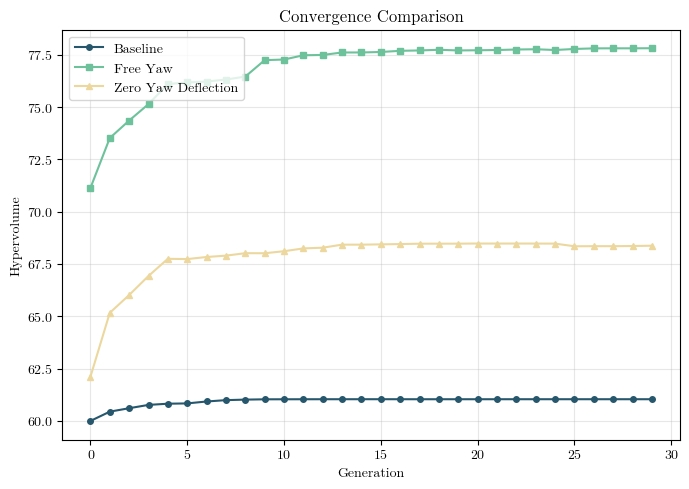

In [ ]:
# Analyze convergence for all three cases
from pymoo.indicators.hv import Hypervolume


# Function to calculate hypervolume history for a result
def calculate_hv_history(result):
    n_evals = []
    hist_F = []
    hist_cv = []
    hist_cv_avg = []

    for algo in result.history:
        n_evals.append(algo.evaluator.n_eval)
        opt = algo.opt
        hist_cv.append(opt.get("CV").min())
        hist_cv_avg.append(algo.pop.get("CV").mean())
        feas = np.where(opt.get("feasible"))[0]
        hist_F.append(opt.get("F")[feas])

    approx_ideal = result.F.min(axis=0)
    approx_nadir = result.F.max(axis=0)
    ref_point = approx_nadir

    metric = Hypervolume(
        ref_point=ref_point,
        norm_ref_point=False,
        zero_to_one=False,
        ideal=approx_ideal,
        nadir=approx_nadir,
    )

    hv = [metric.do(_F) for _F in hist_F]
    return hv, n_evals


# Calculate hypervolume for all cases
hv_baseline, n_evals_baseline = calculate_hv_history(result_baseline)
hv_free_yaw, n_evals_free_yaw = calculate_hv_history(result_free_yaw)
hv_zero_yaw, n_evals_zero_yaw = calculate_hv_history(result_zero_yaw)

# Plot convergence for all three cases
plt.figure(figsize=(7, 5))
plt.plot(hv_baseline, "o-", lw=1.5, label="Baseline", markersize=4)
plt.plot(hv_free_yaw, "s-", lw=1.5, label="Free Yaw", markersize=4)
plt.plot(hv_zero_yaw, "^-", lw=1.5, label="Zero Yaw Deflection", markersize=4)
plt.title("Convergence Comparison")
plt.xlabel("Generation")
plt.ylabel("Hypervolume")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

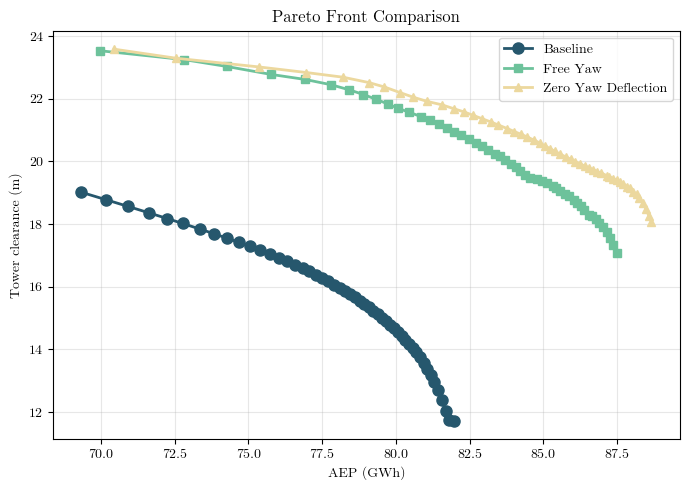

In [ ]:
# Pareto front comparison - all three cases
pareto_baseline = -result_baseline.F[result_baseline.F[:, 0].argsort()]  # type: ignore
pareto_free_yaw = -result_free_yaw.F[result_free_yaw.F[:, 0].argsort()]  # type: ignore
pareto_zero_yaw = -result_zero_yaw.F[result_zero_yaw.F[:, 0].argsort()]  # type: ignore

plt.figure(figsize=(7, 5))
plt.plot(
    *np.transpose(pareto_baseline),
    "o-",
    label="Baseline",
    linewidth=2,
    markersize=8,
)
plt.plot(
    *np.transpose(pareto_free_yaw),
    "s-",
    label="Free Yaw",
    linewidth=2,
    markersize=6,
)
plt.plot(
    *np.transpose(pareto_zero_yaw),
    "^-",
    label="Zero Yaw Deflection",
    linewidth=2,
    markersize=6,
)
plt.legend()
plt.xlabel("AEP (GWh)")
plt.ylabel("Tower clearance (m)")
plt.title("Pareto Front Comparison")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

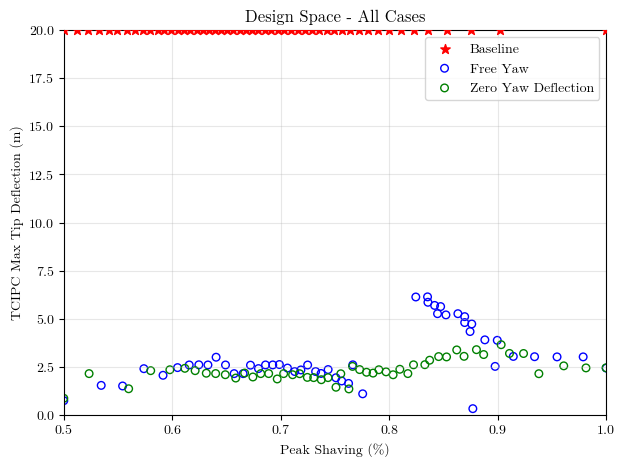

In [33]:
# Visualize design space for all three cases
xl, xu = problem_free_yaw.bounds()
plt.figure(figsize=(7, 5))
plt.scatter(
    result_baseline.X[:, 0],
    result_baseline.X[:, 1],
    s=50,
    marker="*",
    c="red",
    label="Baseline",
    zorder=3,
)
plt.scatter(
    result_free_yaw.X[:, 0],
    result_free_yaw.X[:, 1],
    s=30,
    facecolors="none",
    edgecolors="blue",
    label="Free Yaw",
)
plt.scatter(
    result_zero_yaw.X[:, 0],
    result_zero_yaw.X[:, 1],
    s=30,
    facecolors="none",
    edgecolors="green",
    label="Zero Yaw Deflection",
)
plt.xlim(xl[0], xu[0])
plt.ylim(xl[1], xu[1])
plt.xlabel("Peak Shaving (%)")
plt.ylabel("TCIPC Max Tip Deflection (m)")
plt.title("Design Space - All Cases")
plt.legend()
plt.grid(alpha=0.3)
plt.show()